In [1]:
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Dropout, GlobalAveragePooling2D, Flatten, Dense, AvgPool2D, MaxPool2D
from keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.callbacks import EarlyStopping

import tensorflow as tf

import shutil

from PIL import Image, ImageOps
import keras.applications.efficientnet as efn

import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

In [2]:
data_dir='Coronahack-Chest-XRay-Dataset'
summary=pd.read_csv('Chest_xray_Corona_dataset_Summary.csv')
df=pd.read_csv('Chest_xray_Corona_Metadata.csv')
df['Label']=df['Label'].replace({'Pnemonia':1, 'Normal':0})

In [3]:
train_df=df[df['Dataset_type']=='TRAIN']
test_df=df[df['Dataset_type']=='TEST']

In [4]:
train_path='Working/train/'
test_path='Working/test/'

In [5]:
df['Label'][0]

0

In [6]:
df

,Unnamed: 0,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category
0,0,IM-0128-0001.jpeg,0,TRAIN,NaN,NaN
1,1,IM-0127-0001.jpeg,0,TRAIN,NaN,NaN
2,2,IM-0125-0001.jpeg,0,TRAIN,NaN,NaN
3,3,IM-0122-0001.jpeg,0,TRAIN,NaN,NaN
4,4,IM-0119-0001.jpeg,0,TRAIN,NaN,NaN
...,...,...,...,...,...,...
5905,5928,person1637_virus_2834.jpeg,1,TEST,NaN,Virus
5906,5929,person1635_virus_2831.jpeg,1,TEST,NaN,Virus
5907,5930,person1634_virus_2830.jpeg,1,TEST,NaN,Virus
5908,5931,person1633_virus_2829.jpeg,1,TEST,NaN,Virus


In [7]:
# Seperate dataframes for different labels in test and train
train_pneumonia_df = train_df[train_df.Label==1]
train_normal_df = train_df[train_df.Label==0]
test_pneumonia_df = test_df[test_df.Label==1]
test_normal_df = test_df[test_df.Label==0]

In [8]:
for i in range(len(df)):
    if df['Dataset_type'][i]=='TRAIN':
        dir='imgs/train/'
        if df['Label'][i]==0:
            destination='Working/train/Normal/'
            shutil.copy(dir+str(df['X_ray_image_name'][i]), destination)
        elif df['Label'][i]==1:
            destination='Working/train/Pneumonia'
            shutil.copy(dir+str(df['X_ray_image_name'][i]), destination)
    elif df['Dataset_type'][i]=='TEST':
        dir='imgs/test/'
        if df['Label'][i]==0:
            destination='Working/test/Normal/'
            shutil.copy(dir+str(df['X_ray_image_name'][i]), destination)
        elif df['Label'][i]==1:
            destination='Working/test/Pneumonia'
            shutil.copy(dir+str(df['X_ray_image_name'][i]), destination)

In [9]:
training_images_pneumonia=train_pneumonia_df['X_ray_image_name'].values.tolist()

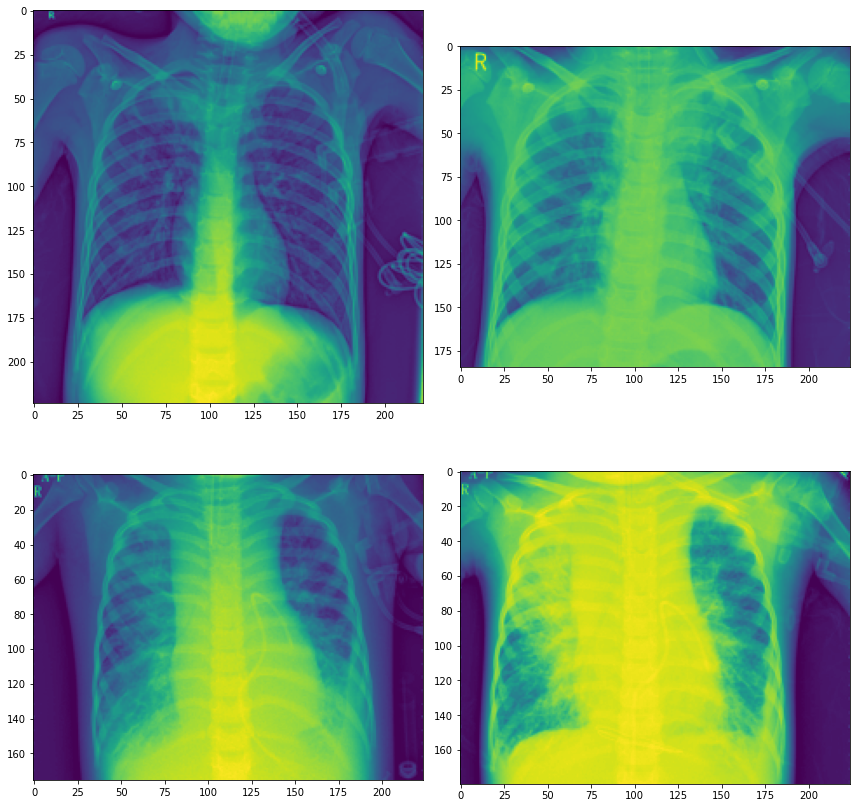

In [10]:
plt.figure(figsize=(12,12))
for index, fn in enumerate(training_images_pneumonia[:4]):
    path='Working/train/Pneumonia/'+str(fn)
    image=Image.open(path)
    image=ImageOps.grayscale(image)
    image.thumbnail((224,224))
    plt.subplot(2,2,index+1)
    plt.imshow(image)
plt.tight_layout()

In [11]:
#Model parameters
batch_size=64
img_width, img_height, img_num_channels=224,224,3
epochs=15
verbosity=1
input_shape=(img_width, img_height, img_num_channels)

In [12]:
#Creating an Efficient Net Model
model_b7=efn.EfficientNetB7(weights='imagenet', input_shape=input_shape, include_top=False)

In [13]:
train_datagen=ImageDataGenerator(rescale=1./255,
shear_range=0.2,
rotation_range=0.2,
width_shift_range=0.2,
height_shift_range=0.2,
zoom_range=0.2,
horizontal_flip=True,
vertical_flip=True,
fill_mode='nearest')

train_generator=train_datagen.flow_from_directory(train_path, target_size=(224,224), batch_size=batch_size, class_mode='binary')

valid_datagen=ImageDataGenerator(rescale=1./255)
valid_generator=valid_datagen.flow_from_directory(test_path, target_size=(224,224), batch_size=batch_size, class_mode='binary')

pretrained_model=model_b7
pretrained_model.trainable=True
set_trainable=False

Found 5286 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [14]:
model=Sequential()
model.add(pretrained_model)
model.add(MaxPooling2D(name="MaxPool_"))
model.add(Dropout(0.2, name="dropout_out"))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

es_callback = EarlyStopping(monitor='val_auc', mode='max', patience=8,
                                              verbose=1, min_delta=0.0001, restore_best_weights=True)

history = model.fit(train_generator,
                    steps_per_epoch=train_generator.samples//batch_size,
                    epochs = epochs,
                    validation_data=valid_generator,
                    validation_steps=valid_generator.samples//batch_size,
                    callbacks= [es_callback],
                    verbose=verbosity)

Epoch 1/15
14/82 [====>.........................] - ETA: 3:55:04 - loss: 0.5473 - accuracy: 0.8225

In [1]:
#I don't have the resources for this